## Target Testing

This Notebook intends to study the distribution of the target, assessing its pertinence and its capacity to accurately describe the financial trend. We will use different target parameters, such as the period, the goalreturn and the option logreturn in order to find which parameters most successfully describe the financial trend. 

Lastly, the best parameters will be defined as the default parameters of the method add_target 





In [1]:
import sys
from pathlib import Path
import pandas as pd

PROJECT_ROOT = Path.cwd().parent
sys.path.insert(0, str(PROJECT_ROOT))

In [2]:
from src.data_loader import load_data

spy = load_data()
spy.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
0,2000-01-03 00:00:00-05:00,93.388752,93.388752,90.632760,91.617043,8164300,0.0,0.0,0.0
1,2000-01-04 00:00:00-05:00,90.416213,90.750869,87.965349,88.034248,8089800,0.0,0.0,0.0
2,2000-01-05 00:00:00-05:00,88.152386,89.156355,86.459419,88.191757,12177900,0.0,0.0,0.0
3,2000-01-06 00:00:00-05:00,87.955531,89.136670,86.774391,86.774391,6227200,0.0,0.0,0.0
4,2000-01-07 00:00:00-05:00,88.388644,91.813950,88.231158,91.813950,8066500,0.0,0.0,0.0


In [3]:
from src.features import add_MA, add_EMA, add_returns, add_volatility, add_distances, add_cumulated_returns, add_rsi, add_target, add_all_features, add_target_ma_cross

df2 = spy.copy()
df2 = add_all_features(df2)

periods = [15, 30, 60, 90]
goalreturns = [0.03, 0.05, 0.07, 0.1]

def hyperparameters_testing(df: pd.DataFrame, periods=periods, goalreturns=goalreturns):

    for period in periods:
        for goalreturn in goalreturns:
            df = df.copy()
            df = add_target(df, period=period, goalreturn=goalreturn)


            print(f'Period of the test: {period}')
            print(f'Goalreturn of the test: {goalreturn}')
            print(df['Trend'].value_counts(normalize=True))
            print('\n--------------------------------------\n')
            

hyperparameters_testing(df2)



Period of the test: 15
Goalreturn of the test: 0.03
Trend
Non-Bullish    0.773855
Bullish        0.226145
Name: proportion, dtype: float64

--------------------------------------

Period of the test: 15
Goalreturn of the test: 0.05
Trend
Non-Bullish    0.922233
Bullish        0.077767
Name: proportion, dtype: float64

--------------------------------------

Period of the test: 15
Goalreturn of the test: 0.07
Trend
Non-Bullish    0.967239
Bullish        0.032761
Name: proportion, dtype: float64

--------------------------------------

Period of the test: 15
Goalreturn of the test: 0.1
Trend
Non-Bullish    0.990458
Bullish        0.009542
Name: proportion, dtype: float64

--------------------------------------

Period of the test: 30
Goalreturn of the test: 0.03
Trend
Non-Bullish    0.615458
Bullish        0.384542
Name: proportion, dtype: float64

--------------------------------------

Period of the test: 30
Goalreturn of the test: 0.05
Trend
Non-Bullish    0.803117
Bullish        0.19

### Hyperparameter Selection Rationale

After testing multiple configurations, we select **(period=60, goalreturn=0.05)** for the following reasons:

1. **Financial interpretation**: This configuration captures periods where SPY exhibits strong bullish momentum (>30% annualized return over 2 months), which corresponds to genuine bull market conditions rather than normal drift.

2. **Class distribution**: The resulting distribution is 37% Bullish / 63% Non-Bullish. While imbalanced, this reflects market reality: strong bull periods are less frequent than moderate growth or bearish periods. This ratio remains sufficient for supervised learning without extreme class imbalance.

3. **Time horizon**: 60 (trading) days represents a medium-term trend that is:
   - Long enough to filter out short-term noise
   - Short enough to capture multiple bull/non-bull cycles in our 20+ year dataset
   - Relevant for swing trading or tactical allocation strategies

4. **Comparison with alternatives**:
   - (60, 0.03) produces 52/48 balance but defines "Bullish" too leniently (~18% annualized)
   - (90, 0.05) produces better balance (46/54) but reduces the number of independent observations
   - (60, 0.05) strikes the best compromise between financial rigor and modeling feasibility

In [4]:
df1 = spy.copy()
df1 = add_all_features(df1)
df1 = add_target(df1, period=60, goalreturn=0.05)

df1 = df1.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1)
df1.head()

,Date,Open,High,Low,Close,Volume,MA10,MA50,EMA20,Return,Log Return,Volatility,Distance_MA50,Distance_EMA20,Cumulated_Return_5d,RSI14,Trend
0,2000-01-03 00:00:00-05:00,93.388752,93.388752,90.632760,91.617043,8164300,NaN,NaN,91.617043,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,Non-Bullish
1,2000-01-04 00:00:00-05:00,90.416213,90.750869,87.965349,88.034248,8089800,NaN,NaN,89.736076,-0.039106,-0.039891,NaN,NaN,-0.018965,NaN,NaN,Bullish
2,2000-01-05 00:00:00-05:00,88.152386,89.156355,86.459419,88.191757,12177900,NaN,NaN,89.169011,0.001789,0.001788,NaN,NaN,-0.010960,NaN,NaN,Bullish
3,2000-01-06 00:00:00-05:00,87.955531,89.136670,86.774391,86.774391,6227200,NaN,NaN,88.477721,-0.016071,-0.016202,NaN,NaN,-0.019252,NaN,NaN,Bullish
4,2000-01-07 00:00:00-05:00,88.388644,91.813950,88.231158,91.813950,8066500,NaN,NaN,89.284727,0.058077,0.056453,NaN,NaN,0.028328,NaN,NaN,Non-Bullish


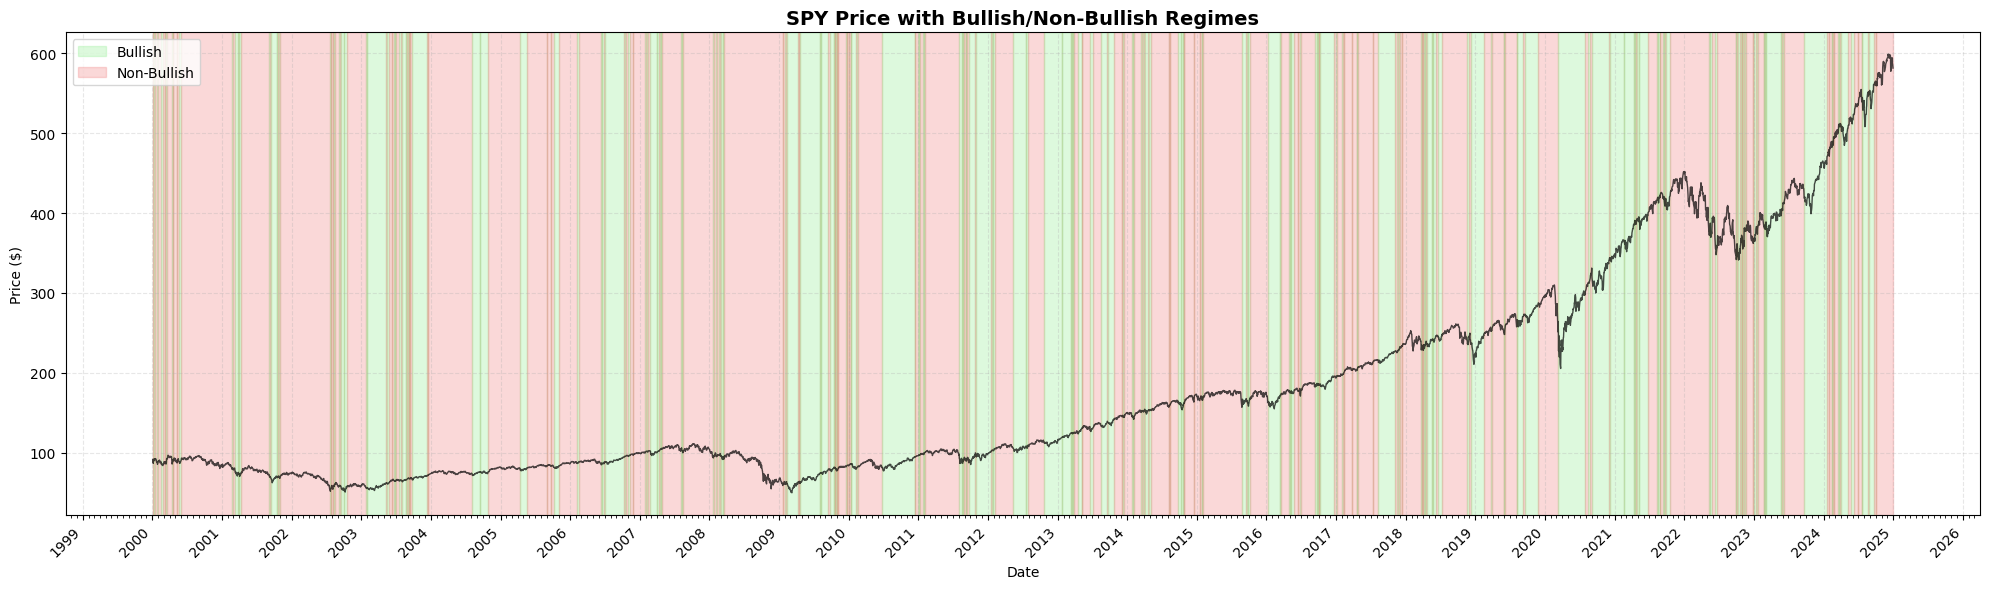

In [26]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(20, 6)) 

ax.plot(df1['Date'], df1['Close'], color='black', linewidth=1, alpha=0.7)

# Colors labels
colors = {
    'Bullish': 'lightgreen',
    'Non-Bullish': 'lightcoral'
}

#Colored zones and dates
label = df1['Trend'].iloc[0]
start_date = df1['Date'].iloc[0]

for i in range(1, len(df1)):
    if df1['Trend'].iloc[i] != label:
        ax.axvspan(start_date, df1['Date'].iloc[i], 
                   color=colors[label], alpha=0.3)
        label = df1['Trend'].iloc[i]
        start_date = df1['Date'].iloc[i]

ax.axvspan(start_date, df1['Date'].iloc[-1], 
           color=colors[label], alpha=0.3)


ax.xaxis.set_major_locator(mdates.YearLocator())        
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())       

#Label rotation
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


ax.set_title('SPY Price with Bullish/Non-Bullish Regimes', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')


bullish_patch = mpatches.Patch(color='lightgreen', alpha=0.3, label='Bullish')
bearish_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='Non-Bullish')
ax.legend(handles=[bullish_patch, bearish_patch], loc='upper left')


ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()


In [19]:
transitions = (df1['Trend'] != df1['Trend'].shift(1)).sum()
print(f"Nombre de transitions: {transitions}")

#Should be non-bullish (~0%)
print("2008 (crisis):", (df1[df1['Date'].dt.year == 2008]['Trend'] == 'Bullish').mean())

#Should be non-bullish (~50%)
print("2013-2017 (bull run):", (df1[df1['Date'].dt.year.isin([2013,2014,2015,2016,2017])]['Trend'] == 'Bullish').mean())



Nombre de transitions: 441
2008 (crisis): 0.05928853754940711
2013-2017 (bull run): 0.3375694996028594


## Fundamental issue with the current target model

With our actual approach, which is labelling financial trends based on future return on a certain period of time results in many problems.

1. Transitions
The number of transitions between Bullish and Non-Bullish is way too numerous. Even by smoothing prices trough a SMA of length 5-10 days (not documented here), the number of transitions was still huge. Concretely, our target is way too responsive to noise and is not able to capture financial trend. Indeed, the correlation between days returns is around 0.99, so even by smoothing prices, transitions were too numerous

2. Financial Trend
As we can see in the graph above and in the numbers shown in the previous cell, the target cannot fully capture these pieces of data. The 2013-2017 bull run was poorly understood by the actual target. More than being sensitive to noise, our target is not efficient

### Consequences

The threshold-based approach suffers from two fundamental issues: (1) excessive label instability due to autocorrelation, and (2) potential misalignment with actual market regimes. Moving average crossovers address both issues by (1) naturally producing fewer transitions (crossovers are rare events), and (2) directly measuring momentum shifts that define regime changes in technical analysis

In [27]:
configs = [
    (10, 50, "Short Term"),
    (20, 60, "Mid Term"),
    (50, 200, "Long Term (Golden Cross)")
]

for short, long, desc in configs:
    df_test = add_target_ma_cross(spy, short_window=short, long_window=long)
    df_valid = df_test.dropna(subset=['Trend'])
    
    transitions = (df_valid['Trend'] != df_valid['Trend'].shift(1)).sum()
    bullish_pct = (df_valid['Trend'] == 'Bullish').mean()
    
    print(f"\n{desc} (MA{short}/MA{long}):")
    print(f"  Observations : {len(df_valid)}")
    print(f"  Transitions : {transitions}")
    print(f"  % Bullish : {bullish_pct:.1%}")



Short Term (MA10/MA50):
  Observations : 6288
  Transitions : 160
  % Bullish : 66.0%

Mid Term (MA20/MA60):
  Observations : 6288
  Transitions : 112
  % Bullish : 67.4%

Long Term (Golden Cross) (MA50/MA200):
  Observations : 6288
  Transitions : 26
  % Bullish : 69.6%


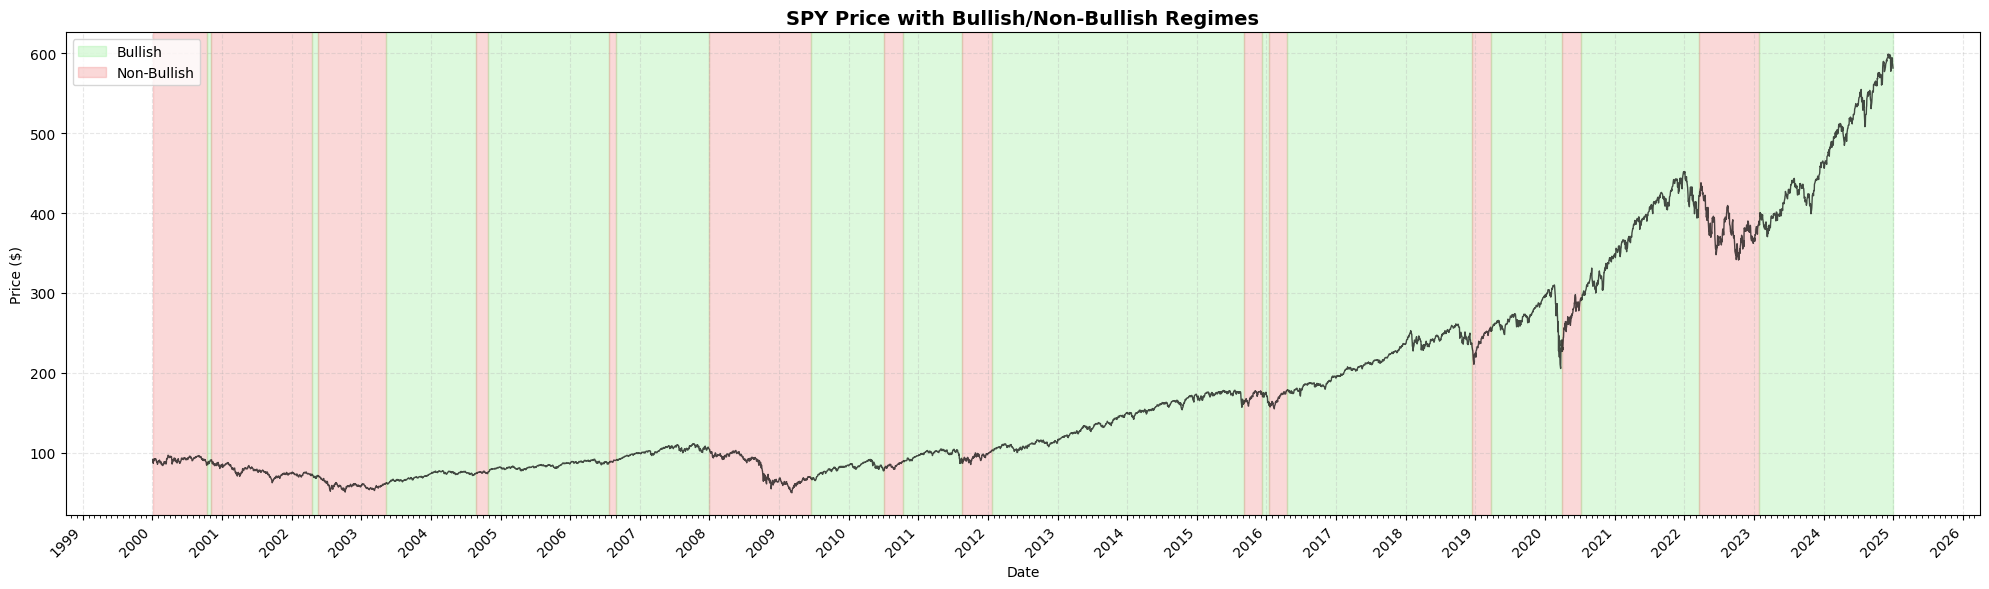

In [28]:
fig, ax = plt.subplots(figsize=(20, 6)) 

ax.plot(df_test['Date'], df_test['Close'], color='black', linewidth=1, alpha=0.7)

# Colors labels
colors = {
    'Bullish': 'lightgreen',
    'Non-Bullish': 'lightcoral'
}

#Colored zones and dates
label = df_test['Trend'].iloc[0]
start_date = df_test['Date'].iloc[0]

for i in range(1, len(df_test)):
    if df_test['Trend'].iloc[i] != label:
        ax.axvspan(start_date, df_test['Date'].iloc[i], 
                   color=colors[label], alpha=0.3)
        label = df_test['Trend'].iloc[i]
        start_date = df_test['Date'].iloc[i]

ax.axvspan(start_date, df_test['Date'].iloc[-1], 
           color=colors[label], alpha=0.3)


ax.xaxis.set_major_locator(mdates.YearLocator())        
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) 
ax.xaxis.set_minor_locator(mdates.MonthLocator())       

#Label rotation
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')


ax.set_title('SPY Price with Bullish/Non-Bullish Regimes', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price ($)')


bullish_patch = mpatches.Patch(color='lightgreen', alpha=0.3, label='Bullish')
bearish_patch = mpatches.Patch(color='lightcoral', alpha=0.3, label='Non-Bullish')
ax.legend(handles=[bullish_patch, bearish_patch], loc='upper left')


ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()


#### The Golden Cross, as it has been proven in past studies, is actually producing less transitions than the previous target and is capturing more precisely the real financial trend

In [49]:
df_clean = spy.copy()
df_clean = add_all_features(df_clean)
df_clean = add_target_ma_cross(df_clean, short_window=50, long_window=200).dropna(subset=['Trend'])
df_clean = df_clean.drop(['Dividends', 'Stock Splits', 'Capital Gains'], axis=1)
df_clean

,Date,Open,High,Low,Close,Volume,MA10,MA50,EMA20,Return,Log Return,Volatility,Distance_MA50,Distance_EMA20,Cumulated_Return_5d,RSI14,Trend
0,2000-01-03 00:00:00-05:00,93.388752,93.388752,90.632760,91.617043,8164300,NaN,NaN,91.617043,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,Non-Bullish
1,2000-01-04 00:00:00-05:00,90.416213,90.750869,87.965349,88.034248,8089800,NaN,NaN,89.736076,-0.039106,-0.039891,NaN,NaN,-0.018965,NaN,NaN,Non-Bullish
2,2000-01-05 00:00:00-05:00,88.152386,89.156355,86.459419,88.191757,12177900,NaN,NaN,89.169011,0.001789,0.001788,NaN,NaN,-0.010960,NaN,NaN,Non-Bullish
3,2000-01-06 00:00:00-05:00,87.955531,89.136670,86.774391,86.774391,6227200,NaN,NaN,88.477721,-0.016071,-0.016202,NaN,NaN,-0.019252,NaN,NaN,Non-Bullish
4,2000-01-07 00:00:00-05:00,88.388644,91.813950,88.231158,91.813950,8066500,NaN,NaN,89.284727,0.058077,0.056453,NaN,NaN,0.028328,NaN,NaN,Non-Bullish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6283,2024-12-23 00:00:00-05:00,584.031655,588.390442,580.839104,587.787537,57635800,590.267542,582.895719,589.035273,0.005988,0.005970,0.008463,0.008392,-0.002118,-0.016642,43.148938,Bullish
6284,2024-12-24 00:00:00-05:00,589.141630,594.360375,588.558452,594.320801,33160100,590.319135,583.270122,589.538656,0.011115,0.011054,0.008789,0.018946,0.008112,-0.001599,46.098014,Bullish
6285,2024-12-26 00:00:00-05:00,592.541682,595.487074,591.138180,594.360352,41219100,589.915637,583.734762,589.997866,0.000067,0.000067,0.008719,0.018203,0.007394,0.029140,46.981897,Bullish
6286,2024-12-27 00:00:00-05:00,590.604424,590.841689,583.903150,588.103821,64969300,589.194812,584.024624,589.817480,-0.010526,-0.010582,0.009024,0.006985,-0.002905,0.018619,40.972849,Bullish


In [50]:
dates = df_clean['Date'].astype(str).apply(lambda x: x[:4])
dates

date_trend_df = pd.DataFrame([dates, df_clean['Trend']]).T
date_trend_df['Trend'] = date_trend_df['Trend'].apply(lambda x: 1 if x == "Bullish" else 0)

infos = date_trend_df.groupby(['Date']).mean()
infos

,Trend
Date,
2000,0.051587
2001,0.000000
2002,0.079365
2003,0.646825
2004,0.825397
2005,1.000000
2006,0.900398
2007,0.992032
2008,0.000000


In [63]:
# Test on the functionning of the definition on other tickers

qqq = load_data(ticker = 'QQQ')
dow = load_data(ticker = 'DIA')

qqq = add_target_ma_cross(qqq, short_window=50, long_window=200)
dow = add_target_ma_cross(dow, short_window=50, long_window=200)
print("Nasdaq")
print(qqq['Trend'].value_counts(normalize=True))
print('\n-------------------------\n')
print("Dow jones")
print(dow['Trend'].value_counts(normalize=True))
print('\n-------------------------\n')
print("SPY")
print(df_clean['Trend'].value_counts(normalize=True))

Nasdaq
Trend
Bullish        0.698632
Non-Bullish    0.301368
Name: proportion, dtype: float64

-------------------------

Dow jones
Trend
Bullish        0.727735
Non-Bullish    0.272265
Name: proportion, dtype: float64

-------------------------

SPY
Trend
Bullish        0.696406
Non-Bullish    0.303594
Name: proportion, dtype: float64


Similar to both the Dow Jones and the Nasdaq, the target seems coherent, now we will test if it is sensitive to a little gaussian noise on the price

Text(0.5, 1.0, 'Price of SPY along time with gaussian noise')

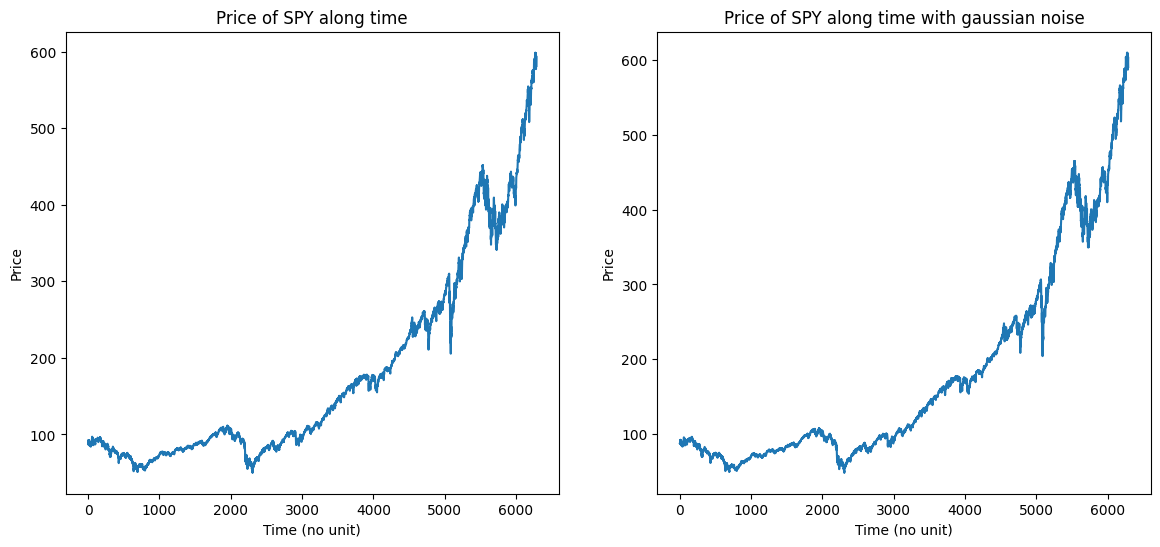

In [52]:

#Add gaussian noise to logreturns and change the target accordingly

def add_gaussian(df: pd.DataFrame, mu = 0, sigma = 0.05):

    df1 = df.copy()

    #Add gaussian to logreturns
    sig = df1['Log Return'].std()
    norm_logreturns = df1['Log Return'] / sig

    rng = np.random.default_rng()
    s = rng.normal(mu, sigma, len(norm_logreturns))
    logreturns_noisy = s + norm_logreturns

    #Reconstruct price based on those new logreturns to change the target
    logreturns_noisy = logreturns_noisy * sig
    df1['Close'] = df1['Close'].iloc[0] * np.exp(logreturns_noisy.cumsum())

    df1 = df1.drop('Trend', axis=1)
    df1 = add_target(df1)

    return df1

gaussian_df_test = add_gaussian(df_clean)

fig, axes = plt.subplots(1, 2, figsize=(14,6))
axes[0].plot(df1['Close'])
axes[0].set_xlabel('Time (no unit)')
axes[0].set_ylabel('Price')
axes[0].set_title('Price of SPY along time')

axes[1].plot(gaussian_df_test['Close'])
axes[1].set_xlabel('Time (no unit)')
axes[1].set_ylabel('Price')
axes[1].set_title('Price of SPY along time with gaussian noise')




In [55]:
import numpy as np



def add_gaussian_and_relabel(df: pd.DataFrame, sigma=0.05, short=50, long=200):
    """
    Ajoute du bruit gaussien aux PRIX (pas log-returns),
    puis recalcule les MA et la target Golden Cross.
    """
    df1 = df.copy()
    
    # Ajouter du bruit gaussien directement aux prix
    noise = np.random.normal(0, sigma * df1['Close'].std(), len(df1))
    df1['Close_noisy'] = df1['Close'] + noise
    
    # Recalculer les MA sur les prix bruités
    ma_short = df1['Close_noisy'].rolling(window=short).mean()
    ma_long = df1['Close_noisy'].rolling(window=long).mean()
    
    # Recalculer la target
    df1['Trend'] = (ma_short > ma_long).map({True: 'Bullish', False: 'Non-Bullish'})
    
    return df1

# Test
sigmas = np.linspace(0.01, 0.5, 50)
flip_rates = []

for s in sigmas:
    flips = []
    for _ in range(50):
        gaussian_df = add_gaussian_and_relabel(df_clean, sigma=s)
        flip_rate = (gaussian_df["Trend"] != df_clean["Trend"]).mean()
        flips.append(flip_rate)
    flip_rates.append(np.mean(flips))

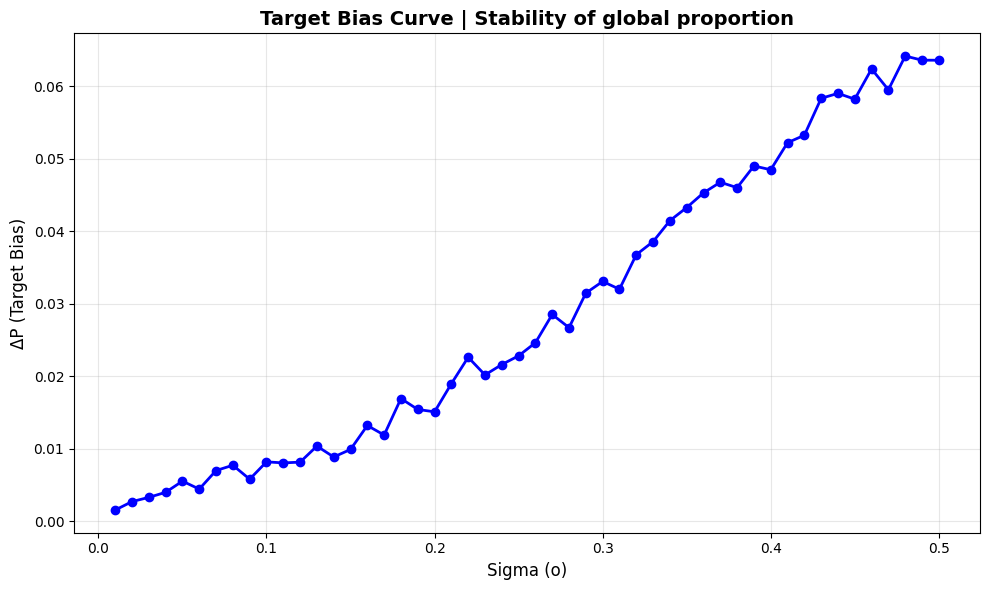

In [58]:
import matplotlib.pyplot as plt


p_bullish_clean = (df_clean['Trend'] == 'Bullish').mean()

distances_noise_clean = []
for s in sigmas:
    distances = []
    for _ in range(50):
        gaussian_df = add_gaussian_and_relabel(df_clean, sigma=s)
        p_bullish_noisy = (gaussian_df['Trend'] == 'Bullish').mean()
        distances.append(abs(p_bullish_noisy - p_bullish_clean))
    distances_noise_clean.append(np.mean(distances))

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sigmas, distances_noise_clean, marker='o', color='blue', linewidth=2)
ax.set_xlabel('Sigma (o)', fontsize=12)
ax.set_ylabel('ΔP (Target Bias)', fontsize=12)
ax.set_title('Target Bias Curve | Stability of global proportion', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()

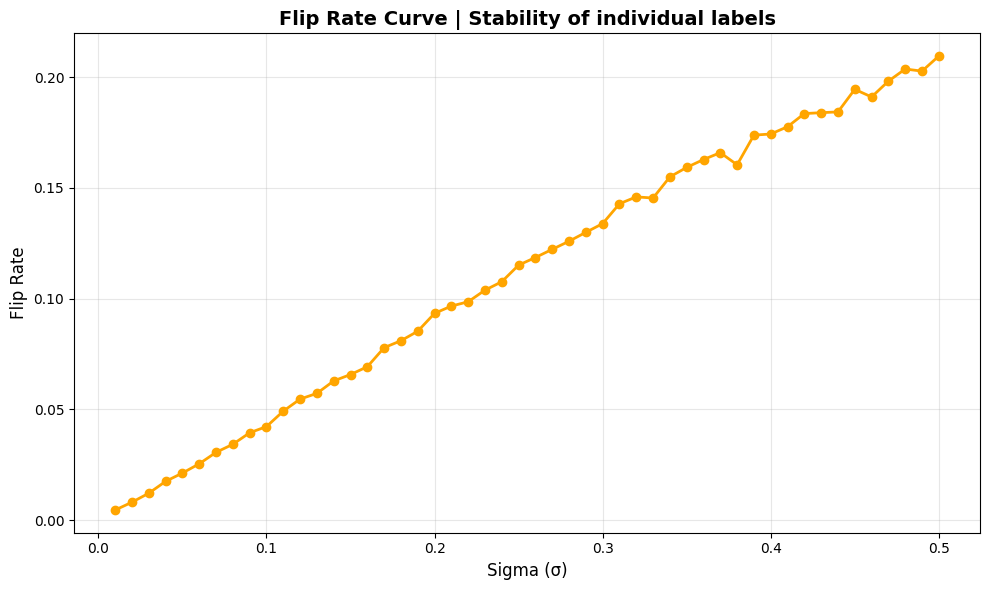

In [59]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(sigmas, flip_rates, marker='o', color='orange', linewidth=2)
ax.set_xlabel('Sigma (σ)', fontsize=12)
ax.set_ylabel('Flip Rate', fontsize=12)
ax.set_title('Flip Rate Curve | Stability of individual labels', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
plt.tight_layout()


## Robustness Analysis of the Target

To evaluate the robustness of our binary trend target, we performed two complementary tests using Gaussian noise added to the log-returns of the SPY stock:

1. **Target Bias Curve (ΔP)**  
   - For each level of Gaussian noise σ ∈ [0.01, 0.5], we computed the absolute difference in the proportion of “Bullish” labels between the noisy and original series.  
   - Results show a maximal ΔP of ~6%, indicating that the global target proportion is largely insensitive to moderate noise. 
   - This suggests that the target captures a structural market trend rather than being sensitive to small fluctuations in price.

2. **Flip Rate Curve Analysis**

   - Proportion of individual labels changing under Gaussian noise increases roughly linearly from 1% to 22% as σ ranges from 0.01 to 0.5.  
   - While the global target proportion remains largely stable, observations near the threshold are pretty sensitive to noise, highlighting local instabilities.  
   - Overall, the Golden Cross target is robust at the macro level, but micro-level label changes are expected when prices oscillate near the crossover boundary between MA50 and MA200.


### Overall Target Robustness Conclusion

Combining insights from both the Target Bias Curve (ΔP) and the Flip Rate Curve:  

- **ΔP (Target Bias)** remains  relatively small (≤ 6%), showing minimal global shift in the proportion of Bullish labels under noise.  
- **Flip Rate** reveals that up to 20% of individual labels can change at higher σ, reflecting local sensitivity near the threshold.  

Together, these analyses confirm that the target definition captures the structural bullish trend robustly at a macro level, while preserving sensitivity to local variations, providing a balanced and reliable binary trend signal for the SPY series.
